### Step 1: Importing Libraries and Loading Data

In this step, we import the necessary libraries for data analysis, clustering, and visualization, including:

- `pandas` for data manipulation
- `numpy` for numerical computations
- `matplotlib` for plotting
- `sklearn` for machine learning models (clustering and evaluation)

We then load the customer and transaction data from CSV files to begin the analysis.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load the data
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Merge the customer profile and transaction data
merged_data = pd.merge(transactions, customers, on='CustomerID')

# Handle missing data if any
merged_data = merged_data.dropna()

# Feature engineering for customer profiling
customer_data = merged_data.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    total_quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
    num_transactions=pd.NamedAgg(column='TransactionID', aggfunc='nunique'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean'),
    recency=pd.NamedAgg(column='TransactionDate', aggfunc=lambda x: (pd.to_datetime('today') - pd.to_datetime(x).max()).days)
).reset_index()

# RFM features: Recency, Frequency, Monetary
customer_data['frequency'] = customer_data['num_transactions']
customer_data['monetary'] = customer_data['total_spent']

# Merge with region data
customer_profile = pd.merge(customer_data, customers[['CustomerID', 'Region']], on='CustomerID')

# Preview the data
customer_profile.head()


,CustomerID,total_spent,total_quantity,num_transactions,avg_transaction_value,recency,frequency,monetary,Region
0,C0001,3354.52,12,5,670.904,85,5,3354.52,South America
1,C0002,1862.74,10,4,465.685,55,4,1862.74,Asia
2,C0003,2725.38,14,4,681.345,155,4,2725.38,South America
3,C0004,5354.88,23,8,669.360,35,8,5354.88,South America
4,C0005,2034.24,7,3,678.080,84,3,2034.24,Asia


### Step 2: Feature Selection and Standardization

In this step, we select the relevant features for clustering based on customer data, which include:

- **total_spent**: The total amount spent by the customer.
- **total_quantity**: The total quantity of products purchased by the customer.
- **num_transactions**: The number of transactions made by the customer.
- **avg_transaction_value**: The average value of each transaction.
- **recency**: The number of days since the customer's last transaction.
- **frequency**: The total number of transactions made by the customer.
- **monetary**: The total amount spent (similar to `total_spent`, but this column might be calculated differently depending on context).

After selecting the features, we standardize them using `StandardScaler` to ensure that each feature contributes equally to the clustering process by normalizing their scales. This step is crucial for ensuring that clustering algorithms perform optimally when features have different units or ranges.


In [3]:
# Select features for clustering
features = ['total_spent', 'total_quantity', 'num_transactions', 'avg_transaction_value', 'recency', 'frequency', 'monetary']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile[features])


### Step 3: Elbow Method for Optimal Number of Clusters

The Elbow Method helps identify the optimal number of clusters for K-Means by plotting the inertia (within-cluster sum of squared distances) for different values of `k`. The optimal `k` corresponds to the "elbow" point in the plot where the inertia decreases at a slower rate.


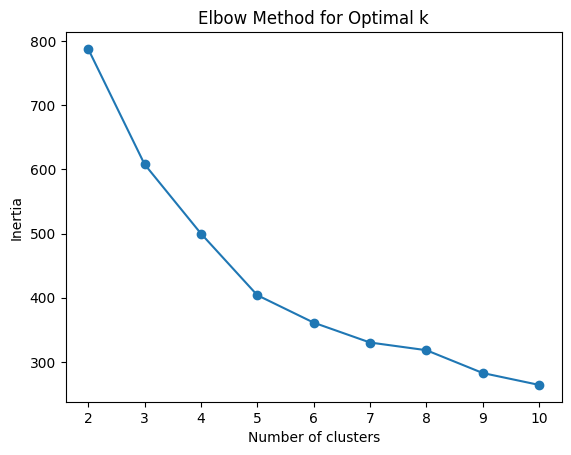

In [4]:
# Elbow Method to find the optimal number of clusters
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()


### Step 4: Silhouette Score to Evaluate Clustering Quality

The Silhouette Score measures the quality of the clusters. A higher score indicates better-defined clusters. We calculate the Silhouette Score for different values of `k` and plot it to find the best number of clusters.


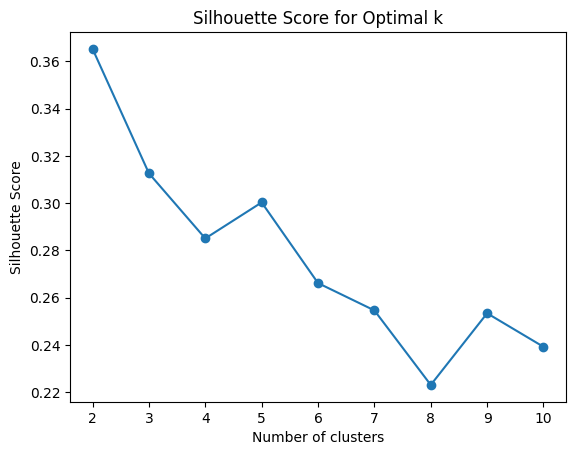

In [5]:
# Silhouette Score to evaluate clustering quality
sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sil_scores.append(silhouette_score(scaled_features, kmeans.labels_))

plt.plot(range(2, 11), sil_scores, marker='o')
plt.title("Silhouette Score for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()


### Step 5: K-Means Clustering with Optimal k

We apply the K-Means algorithm with `k=5`, as suggested by the Elbow and Silhouette analysis. Each customer is assigned to one of the 5 clusters. We also calculate the **Davies-Bouldin Index** and **Silhouette Score** as evaluation metrics for the K-Means clustering.


In [6]:
# K-Means clustering with k=5 (from Elbow Method and Silhouette analysis)
kmeans = KMeans(n_clusters=5, random_state=42)
customer_profile['KMeans_Cluster'] = kmeans.fit_predict(scaled_features)

# KMeans Clustering Evaluation Metrics
kmeans_db_index = davies_bouldin_score(scaled_features, customer_profile['KMeans_Cluster'])
kmeans_sil_score = silhouette_score(scaled_features, customer_profile['KMeans_Cluster'])


### Step 6: DBSCAN Clustering

We apply the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm. DBSCAN is a density-based algorithm that can identify clusters of varying shapes and sizes. It is less sensitive to outliers compared to K-Means. We calculate the Davies-Bouldin Index and Silhouette Score for DBSCAN clustering as well.


In [7]:
from sklearn.cluster import DBSCAN

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_profile['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_features)

# DBSCAN Evaluation Metrics
dbscan_db_index = davies_bouldin_score(scaled_features, customer_profile['DBSCAN_Cluster'])
dbscan_sil_score = silhouette_score(scaled_features, customer_profile['DBSCAN_Cluster'])


### Step 7: Gaussian Mixture Model (GMM) Clustering

The Gaussian Mixture Model (GMM) is a probabilistic model that assumes that the data is generated from a mixture of several Gaussian distributions. We use `n_components=5` for the GMM, and similar to the previous clustering methods, we compute the Davies-Bouldin Index and Silhouette Score for evaluation.


In [8]:
from sklearn.mixture import GaussianMixture

# GMM clustering
gmm = GaussianMixture(n_components=5, random_state=42)
customer_profile['GMM_Cluster'] = gmm.fit_predict(scaled_features)

# GMM Evaluation Metrics
gmm_db_index = davies_bouldin_score(scaled_features, customer_profile['GMM_Cluster'])
gmm_sil_score = silhouette_score(scaled_features, customer_profile['GMM_Cluster'])


### Step 8: Evaluation of Clustering Models

In this step, we evaluate the quality of the clustering results obtained from K-Means, DBSCAN, and Gaussian Mixture Model (GMM) using the following metrics:

- **Davies-Bouldin Index**: This metric evaluates the average similarity ratio of each cluster with its most similar cluster. A lower value indicates better-defined clusters.
- **Silhouette Score**: This metric measures how similar each point is to its own cluster compared to other clusters. A higher value indicates better clustering.

We calculate these metrics for each clustering algorithm (K-Means, DBSCAN, GMM) and print the results to compare their performance.


In [9]:
# KMeans Evaluation Metrics
kmeans_db_index = davies_bouldin_score(scaled_features, customer_profile['KMeans_Cluster'])
kmeans_sil_score = silhouette_score(scaled_features, customer_profile['KMeans_Cluster'])

# DBSCAN Evaluation Metrics
dbscan_db_index = davies_bouldin_score(scaled_features, customer_profile['DBSCAN_Cluster'])
dbscan_sil_score = silhouette_score(scaled_features, customer_profile['DBSCAN_Cluster'])

# GMM Evaluation Metrics
gmm_db_index = davies_bouldin_score(scaled_features, customer_profile['GMM_Cluster'])
gmm_sil_score = silhouette_score(scaled_features, customer_profile['GMM_Cluster'])

# Print evaluation metrics for all models
print("K-Means Clustering DB Index:", kmeans_db_index)
print("K-Means Clustering Silhouette Score:", kmeans_sil_score)

print("DBSCAN Clustering DB Index:", dbscan_db_index)
print("DBSCAN Clustering Silhouette Score:", dbscan_sil_score)

print("GMM Clustering DB Index:", gmm_db_index)
print("GMM Clustering Silhouette Score:", gmm_sil_score)


K-Means Clustering DB Index: 1.0292480594135331
K-Means Clustering Silhouette Score: 0.30030169504588183
DBSCAN Clustering DB Index: 3.6674061264296443
DBSCAN Clustering Silhouette Score: -0.2803591832936114
GMM Clustering DB Index: 1.1706089158426551
GMM Clustering Silhouette Score: 0.20948059637581204


### Step 9: Cluster Visualization using PCA and t-SNE

We use **PCA (Principal Component Analysis)** and **t-SNE (t-Distributed Stochastic Neighbor Embedding)** to reduce the dimensions of the data to 2D for visualization. We then plot the clusters formed by K-Means in a 2D space, which helps in visually assessing how well the clusters are separated.


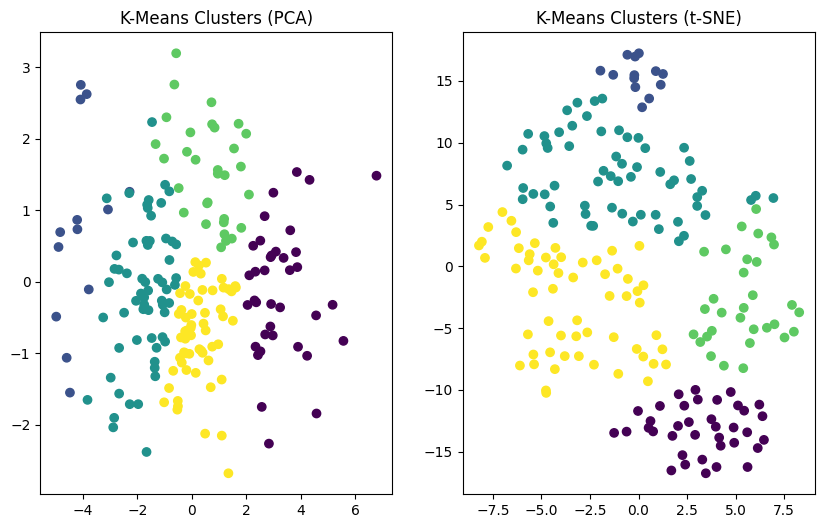

In [10]:
# Dimensionality reduction using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# t-SNE for better visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_features)

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_profile['KMeans_Cluster'], cmap='viridis')
plt.title("K-Means Clusters (PCA)")

plt.subplot(1, 2, 2)
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=customer_profile['KMeans_Cluster'], cmap='viridis')
plt.title("K-Means Clusters (t-SNE)")

plt.show()


### Step 10: Selecting the Best Clustering Algorithm

Based on the evaluation metrics (Silhouette Score), we select the best clustering algorithm. In this case, we compare K-Means, DBSCAN, and GMM and choose the algorithm with the highest Silhouette Score.


In [11]:
# Select the best clustering algorithm based on metrics
best_clustering_algorithm = "K-Means" if kmeans_sil_score > max(dbscan_sil_score, gmm_sil_score) else "DBSCAN" if dbscan_sil_score > gmm_sil_score else "GMM"
print(f"The best clustering algorithm based on Silhouette Score is: {best_clustering_algorithm}")


The best clustering algorithm based on Silhouette Score is: K-Means
